In [1]:
!pip install prettytable


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as tv
from torch.utils.data import DataLoader
import numpy as np
import random

from tqdm import tqdm 
import matplotlib.pyplot as plt 

In [3]:
def set_seed(seed):
    random.seed(seed) 
    np.random.seed(seed)  
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
set_seed(0)

In [4]:
transform = tv.transforms.Compose([
    tv.transforms.Resize(32),
    tv.transforms.CenterCrop(32),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [5]:
label_encoding = {'Fake':0, 'Real':1}
label_decoding = {v:k for k, v in label_encoding.items()}

In [6]:
trainset = tv.datasets.ImageFolder('Image/Train',transform = transform)
validset = tv.datasets.ImageFolder('Image/Valid',transform = transform)
train_loader = DataLoader(trainset, batch_size = 64, shuffle = True, num_workers = 0, pin_memory = True)
valid_loader = DataLoader(validset, batch_size = 64, shuffle = True, num_workers = 0, pin_memory = True)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = tv.models.vgg16(pretrained=False)
model.classifier._modules['6'] = nn.Linear(4096, 2)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [8]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)

In [9]:
from prettytable import PrettyTable 

def count_parameters(model): 
    table = PrettyTable(['Modules', 'Parameters']) 
    total_params = 0 
    for name, parameter in model.named_parameters(): 
        if not parameter.requires_grad: continue 
        params = parameter.numel() 
        table.add_row([name, params]) 
        total_params+=params 
    print(table) 
    print(f'Total Trainable Params: {total_params}') 
    return total_params

count_parameters(model)

+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
|  features.0.weight  |    1728    |
|   features.0.bias   |     64     |
|  features.2.weight  |   36864    |
|   features.2.bias   |     64     |
|  features.5.weight  |   73728    |
|   features.5.bias   |    128     |
|  features.7.weight  |   147456   |
|   features.7.bias   |    128     |
|  features.10.weight |   294912   |
|   features.10.bias  |    256     |
|  features.12.weight |   589824   |
|   features.12.bias  |    256     |
|  features.14.weight |   589824   |
|   features.14.bias  |    256     |
|  features.17.weight |  1179648   |
|   features.17.bias  |    512     |
|  features.19.weight |  2359296   |
|   features.19.bias  |    512     |
|  features.21.weight |  2359296   |
|   features.21.bias  |    512     |
|  features.24.weight |  2359296   |
|   features.24.bias  |    512     |
|  features.26.weight |  2359296   |
|   features.26.bias  |    512     |
|

134268738

In [10]:
def train(epoch):
    train_loss, train_acc = 0, 0
    train_pbar = tqdm(train_loader, position=0, leave=True) # 宣告進度條
    
    model.train() # 將模型切換成訓練模式
    for input_datas in train_pbar: 
        features, labels = [i.to(device) for i in input_datas] # 將資料放入到GPU中
        optimizer.zero_grad()  # 梯度清零
        outputs = model(features) # 模型計算答案(前向傳播)
        
        loss = criterion(outputs, labels) # 計算Loss值
        loss.backward() # 返向傳播
        optimizer.step() # 更新模型權重
        
        train_pbar.set_description(f'Train Epoch {epoch}')  # 顯示訓練次數
        train_pbar.set_postfix({'loss':f'{loss:.3f}'}) # 顯示當下模型損失
        
        _, pred = torch.max(outputs, dim = 1)  # 計算類別
        train_acc += sum(pred == labels) # 計算預測成功的數量
        train_loss += loss.item()  # 模型總損失

    return train_loss/len(train_loader), train_acc/len(trainset) # 計算一次訓練的Loss與準確率


def valid(epoch):
    valid_loss, valid_acc = 0, 0
    valid_pbar = tqdm(valid_loader, position=0, leave=True)
    
    model.eval()
    with torch.no_grad(): 
        for input_datas in valid_pbar:
            features, labels = [i.to(device) for i in input_datas]
            outputs = model(features) 
            loss = criterion(outputs, labels)

            valid_pbar.set_description(f'Valid Epoch {epoch}')
            valid_pbar.set_postfix({'loss':f'{loss:.3f}'})

            _, pred = torch.max(outputs, dim = 1) 
            valid_acc += sum(pred == labels)
            valid_loss += loss.item()

    return valid_loss/len(valid_loader), valid_acc/len(validset)

        
def show_training_loss(loss_record):
    train_loss, valid_loss = [i for i in loss_record.values()]
    
    plt.plot(train_loss)
    plt.plot(valid_loss)
    #標題
    plt.title('Result')
    #y軸標籤
    plt.ylabel('Loss')
    #x軸標籤
    plt.xlabel('Epoch')
    #顯示折線的名稱
    plt.legend(['train', 'valid'], loc='upper left')
    #顯示折線圖
    plt.show()

Valid Epoch 0: 100%|██████████| 313/313 [00:17<00:00, 17.66it/s, loss=0.350]


Saving Model With Acc 0.88980
Train Loss: 0.57481 Train Acc: 0.63377| Valid Loss: 0.25936 Valid Acc: 0.88980| Best Acc: 0.88980



Valid Epoch 1: 100%|██████████| 313/313 [00:16<00:00, 18.91it/s, loss=0.095]


Saving Model With Acc 0.95730
Train Loss: 0.13456 Train Acc: 0.94797| Valid Loss: 0.11062 Valid Acc: 0.95730| Best Acc: 0.95730



Valid Epoch 2: 100%|██████████| 313/313 [00:15<00:00, 20.04it/s, loss=0.144]


Saving Model With Acc 0.97275
Train Loss: 0.06085 Train Acc: 0.97757| Valid Loss: 0.08331 Valid Acc: 0.97275| Best Acc: 0.97275



Valid Epoch 3: 100%|██████████| 313/313 [00:15<00:00, 19.70it/s, loss=0.004]


Saving Model With Acc 0.98230
Train Loss: 0.04095 Train Acc: 0.98506| Valid Loss: 0.04899 Valid Acc: 0.98230| Best Acc: 0.98230



Valid Epoch 4: 100%|██████████| 313/313 [00:16<00:00, 19.07it/s, loss=0.004]


Train Loss: 0.03502 Train Acc: 0.98755| Valid Loss: 0.09834 Valid Acc: 0.97165| Best Acc: 0.98230



Valid Epoch 5: 100%|██████████| 313/313 [00:16<00:00, 18.89it/s, loss=0.018]


Saving Model With Acc 0.98510
Train Loss: 0.02721 Train Acc: 0.99032| Valid Loss: 0.04692 Valid Acc: 0.98510| Best Acc: 0.98510



Valid Epoch 6: 100%|██████████| 313/313 [00:17<00:00, 18.20it/s, loss=0.055]


Train Loss: 0.02244 Train Acc: 0.99219| Valid Loss: 0.06295 Valid Acc: 0.98000| Best Acc: 0.98510



Valid Epoch 7: 100%|██████████| 313/313 [00:17<00:00, 18.21it/s, loss=0.000]


Train Loss: 0.02445 Train Acc: 0.99152| Valid Loss: 0.05014 Valid Acc: 0.98210| Best Acc: 0.98510



Valid Epoch 8: 100%|██████████| 313/313 [00:16<00:00, 19.10it/s, loss=0.139]


Train Loss: 0.01587 Train Acc: 0.99437| Valid Loss: 0.04219 Valid Acc: 0.98505| Best Acc: 0.98510



Valid Epoch 9: 100%|██████████| 313/313 [00:16<00:00, 18.62it/s, loss=0.000]


Saving Model With Acc 0.98700
Train Loss: 0.01613 Train Acc: 0.99448| Valid Loss: 0.04624 Valid Acc: 0.98700| Best Acc: 0.98700



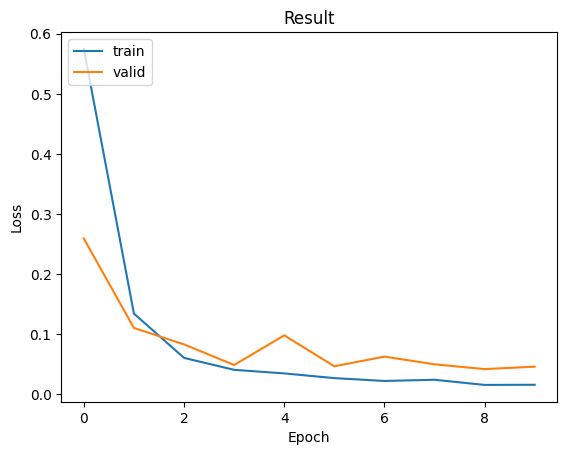

In [11]:
epochs = 10                              # 訓練次數
early_stopping = 5                      # 模型訓練幾次沒進步就停止
stop_cnt = 0                             # 計數模型是否有進步的計數器
model_path = 'model.ckpt'                # 模型存放路徑
show_loss = True                         # 是否顯示訓練折線圖
best_acc = 0                             # 最佳的準確率
loss_record = {'train':[], 'valid':[]}   # 訓練紀錄

for epoch in range(epochs):   
    train_loss, train_acc = train(epoch)
    valid_loss, valid_acc = valid(epoch)
    
    loss_record['train'].append(train_loss)
    loss_record['valid'].append(valid_loss)
    
    # 儲存最佳的模型權重
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), model_path)
        print(f'Saving Model With Acc {best_acc:.5f}')
        stop_cnt = 0
    else:
        stop_cnt+=1
    
    # Early stopping
    if stop_cnt == early_stopping:
        output = "Model can't improve, stop training"
        print('-' * (len(output)+2))
        print(f'|{output}|')
        print('-' * (len(output)+2))
        break
        
    print(f'Train Loss: {train_loss:.5f} Train Acc: {train_acc:.5f}', end='| ')
    print(f'Valid Loss: {valid_loss:.5f} Valid Acc: {valid_acc:.5f}', end='| ')
    print(f'Best Acc: {best_acc:.5f}', end ='\n\n')

if show_loss:
    show_training_loss(loss_record)
        

In [12]:
model = tv.models.vgg16(pretrained=True)
model.classifier._modules['6'] = nn.Linear(4096, 2)
model.to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
new_valid = list(validset)

Real Label: Fake
Pred Label: Fake


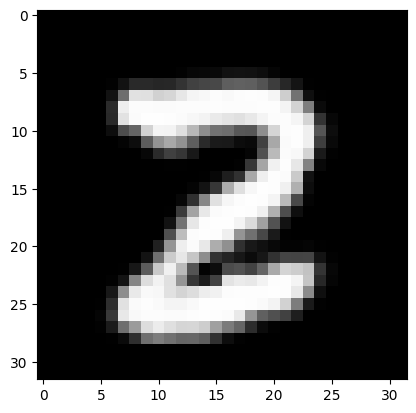

In [14]:
x_valid, y_valid = new_valid[0]
label_decoding = {0:'Fake', 1:'Real'}
img = x_valid.unsqueeze(0).to(device)    # 將圖片新增維度
output = model(img)                          # 計算各類別機率
_, pred = torch.max(output, dim = 1)        # 找到最大機率的位子 
npimg = (x_valid/2+0.5).numpy()          # 還原正規化
npimg = np.transpose(npimg, (1, 2, 0))       # 維度還原

plt.imshow(npimg)                            # 顯示圖片
print('Real Label:',label_decoding[y_valid])                 # 顯示文字 
print('Pred Label:',label_decoding[pred[0].tolist()])